<a href="https://colab.research.google.com/github/AdityaSamantaroy/Recommendation-Engine/blob/master/CFNet_v8working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

refactored. tuned. hparam. hitrate has bug. added goals

# Imports, loading datasets

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from zipfile import ZipFile


from pathlib import Path
from tensorflow import keras
# from tf.keras.layers import Embedding
# import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive

#mount gdrive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
million = True

Mount Google Drive and create necessary directories

In [ ]:
if million == False:

  movielens_data_file_url = (
      "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
  )

  # movielens_data_file_url_1m = (
  #     "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
  # )
  # "http://files.grouplens.org/datasets/movielens/ml-100k.zip"

  base_dir =  "/content/gdrive/My Drive/Machine Learning/movielens/" #"/content/gdrive/My Drive/Machine Learning/movielens1m/"
  if not os.path.isdir(base_dir):
    os.makedirs(base_dir)

  if not os.path.isfile(base_dir + "data.zip"):
    dataset_zip = tf.keras.utils.get_file(
        fname=base_dir + "data.zip", 
        origin=movielens_data_file_url, 
        # extract=True,
    )
    print(dataset_zip)

  if not os.path.isdir(base_dir + "data/"):
    !unzip "/content/gdrive/My Drive/Machine Learning/movielens/data.zip" -d "/content/gdrive/My Drive/Machine Learning/movielens/data"

  root_dir = base_dir +  "data/ml-latest-small/" #"data/ml-1m/"
  ratings_dir = root_dir + "ratings.csv"
  movies_dir = root_dir + "movies.csv"



else:
  movielens_data_file_url_1m = (
      "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
  )
  # movielens_data_file_url = (
  #     "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
  # )
  # "http://files.grouplens.org/datasets/movielens/ml-100k.zip"

  base_dir =  "/content/gdrive/My Drive/Machine Learning/movielens1m/"#"/content/gdrive/My Drive/Machine Learning/movielens/" #
  if not os.path.isdir(base_dir):
    os.makedirs(base_dir)

  if not os.path.isfile(base_dir + "data.zip"):
    dataset_zip = tf.keras.utils.get_file(
        fname=base_dir + "data.zip", 
        origin=movielens_data_file_url_1m, 
        # extract=True,
    )
    print(dataset_zip)

  if not os.path.isdir(base_dir + "data/"):
    !unzip "/content/gdrive/My Drive/Machine Learning/movielens1m/data.zip" -d "/content/gdrive/My Drive/Machine Learning/movielens1m/data"

  root_dir = base_dir +  "data/ml-1m/"#"data/ml-latest-small/" #
  ratings_dir = root_dir + "ratings.dat"
  movies_dir = root_dir + "movies.dat"



Load the datasets

In [ ]:
if million == False:
  df_ratings = pd.read_csv(ratings_dir)
  # df_ratings
else:
  df_ratings = pd.read_csv(ratings_dir, delimiter='::', header = None)
  df_ratings.columns = ['userId', 'movieId', 'rating', 'timestamp']
  # df_ratings

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [ ]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
if million == False:
  df_movies = pd.read_csv(movies_dir)
  # df_movies
else:
  df_movies = pd.read_csv(movies_dir, delimiter='::', header=None)
  df_movies.columns = ['movieId', 'title', 'genres']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


In [ ]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


# Prepare the data
use leave k validation split


Prepare the data

In [ ]:
def split_train_eval(df_ratings, k):
  """
  returns train set and eval set
  """
  # df_ratings['user_mean_bias'] = user_mean_bias.loc[df_ratings['userId'].values].values                   #comment for v1
  # df_ratings['movie_mean_bias'] = movie_mean_bias.loc[df_ratings['movieId'].values].values                   #comment for v1

  leftOutPredictions =df_ratings.groupby('userId', as_index = False).apply(lambda x: x.iloc[-k:,:])
  
  # print(leftOutPredictions)

  # df_ratings_train = df_ratings[~(df_ratings.isin(leftOutPredictions.values))]
  df_ratings_train = df_ratings.groupby('userId', as_index = False).apply(lambda x: x.iloc[:-k,:])#.reset_index(drop = True,inplace =True)
  df_ratings_train.index = pd.RangeIndex(len(df_ratings_train.index))

  # display(df_ratings_train)

  return df_ratings_train, leftOutPredictions

In [ ]:
def prepare_data_leftout(df_ratings, k=20):
  # x = df_ratings[['userId', 'movieId']]
  # y = df_ratings[['rating']]

  # y_min = min(y.values)
  # y_max = max(y.values)

  # y = (y - y_min)/(y_max - y_min)

  # # global_avg = (global_avg - y_min)/(y_max - y_min)

  # user_mean_bias = df_ratings.groupby('userId')['rating'].agg('mean')
  # movie_mean_bias = df_ratings.groupby('movieId')['rating'].agg('mean')
  # user_mean_bias = (user_mean_bias- y_min)/(y_max - y_min)# - global_avg
  # movie_mean_bias = (movie_mean_bias- y_min)/(y_max - y_min)#- global_avg
  # # print(user_mean_bias)
  # # print(movie_mean_bias)


  # split_index = int(0.9*df_ratings.shape[0]) 

  # x_train, x_test, y_train, y_test = (x.iloc[:split_index,:], x.iloc[split_index:,:], y.iloc[:split_index,:], y.iloc[split_index:,:])

  
  # x['user_mean_bias'] = user_mean_bias.loc[x['userId'].values].values
  # x['movie_mean_bias'] = movie_mean_bias.loc[x['movieId'].values].values

  
  # x['user_mean_bias'] = user_mean_bias.loc[x['userId'].values].values
  # x['movie_mean_bias'] = movie_mean_bias.loc[x['movieId'].values].values

  # return x_train, x_test, y_train, y_test, global_avg

  #############################################
  
  y_min = min(df_ratings['rating'].values)
  y_max = max(df_ratings['rating'].values)

  df_ratings['rating'] = (df_ratings['rating'] - y_min)/ (y_max - y_min)

  split_index = int(0.9*df_ratings.shape[0]) 
  df_ratings_train, df_ratings_test = split_train_eval(df_ratings, k)
  # df_ratings_train, df_ratings_test = df_ratings.iloc[:split_index], df_ratings.iloc[split_index:]

  global_avg = df_ratings_train['rating'].sum()/df_ratings_train.shape[0] 
  # print(global_avg)
  user_mean_bias = df_ratings_train.groupby('userId')['rating'].agg('mean') - global_avg
  movie_mean_bias = df_ratings_train.groupby('movieId')['rating'].agg('mean')  - global_avg

  # print(movie_mean_bias)
  #########################
  # def func(x):
  #   x['rating'] = 0
  #   return x

  # user_test_bias = df_ratings[['userId']].groupby('userId').apply(func)
  # movie_test_bias = df_ratings[['movieId']].groupby('movieId').apply(func)
  ########################

  # user_test_bias['rating'] = 0
  # movie_mean_bias['rating'] = 0
  # print(  user_test_bias['rating'] )
  
  # user_mean_bias = user_mean_bias.append(user_test_bias)
  # movie_mean_bias = movie_mean_bias.append(movie_test_bias)
  
  # print(user_mean_bias)

  # user_mean_bias = user_mean_bias.reindex(, fill_value=0) #user_test_bias.index
  # movie_mean_bias = movie_mean_bias.reindex(range(df_ratings['movieId'].unique().max()+1), fill_value=0) #movie_test_bias.index
  
  # user_mean_bias = pd.DataFrame(range(df_ratings['userId'].unique().max()+1)).join(user_mean_bias, how = 'outer').fillna(0)
  # movie_mean_bias = pd.DataFrame(range(df_ratings['movieId'].unique().max()+1)).join(movie_mean_bias, how = 'outer').fillna(0)
  
  all_user_mean_bias = pd.Series(np.zeros(df_ratings['userId'].unique().max()+1))#, columns = ['userId']
  all_movie_mean_bias = pd.Series(np.zeros(df_ratings['movieId'].unique().max()+1))#, columns = ['movieId']

  all_user_mean_bias.update(user_mean_bias)#, overwrite = True
  all_movie_mean_bias.update(movie_mean_bias)#, overwrite = True
  
  user_mean_bias = all_user_mean_bias
  movie_mean_bias = all_movie_mean_bias
  
  # print(user_mean_bias.loc[df_ratings_train['userId'].values].shape, df_ratings_train['user_mean_bias'].shape )

  df_ratings_train['user_mean_bias'] = user_mean_bias.loc[df_ratings_train['userId'].values].values
  df_ratings_train['movie_mean_bias'] = movie_mean_bias.loc[df_ratings_train['movieId'].values].values

  df_ratings_test['user_mean_bias'] = user_mean_bias.loc[df_ratings_test['userId'].values].values
  df_ratings_test['movie_mean_bias'] = movie_mean_bias.loc[df_ratings_test['movieId'].values].values

  # print(df_ratings_train['user_mean_bias'])

  # df_ratings_train, df_ratings_test = df_ratings.iloc[:split_index], df_ratings.iloc[split_index:]

  x_train, x_test, y_train, y_test = df_ratings_train[['userId', 'movieId','user_mean_bias','movie_mean_bias']], df_ratings_test[['userId', 'movieId','user_mean_bias','movie_mean_bias']], df_ratings_train[['rating']], df_ratings_test[['rating']]
  
  return x_train, x_test, y_train, y_test, global_avg

Ensure Data doesnt leak

In [ ]:
x_train, x_test, y_train, y_test, global_avg = prepare_data_leftout(df_ratings, 10)
num_users = df_ratings['userId'].unique().max() +1
num_movies = df_ratings['movieId'].unique().max() +1
  

In [ ]:
x_train

,userId,movieId,user_mean_bias,movie_mean_bias
0,1,1193,0.148187,0.205220
1,1,661,0.148187,-0.027348
2,1,914,0.148187,0.146011
3,1,3408,0.148187,0.073433
4,1,2355,0.148187,0.071492
...,...,...,...,...
939804,6040,1077,-0.001272,0.088374
939805,6040,1079,-0.001272,0.106344
939806,6040,549,-0.001272,0.051664
939807,6040,2020,-0.001272,0.105144


# Hyperparameters

In [ ]:
hparam = {}

In [ ]:
hparam['lr'] = 0.001
hparam['embeddings_initializer'] = 'glorot_uniform'
hparam['embedding_regularization'] = 1e-6
hparam['embedding_size'] = 30
hparam['pure_CF'] = 0

# Prepare the Models  
a. Bias Recommender  
b. Bias + Collaborative Filtering (Matrix Factorisation)  
c. Pure Collaborative Filtering 

Define the models

In [ ]:
import keras.backend as K

class CFRecommender(tf.keras.Model):
  def __init__(self, num_users, num_movies, global_avg, hparam):
    super().__init__()#CFRecommender, self
    self.num_users = num_users
    self.num_movies = num_movies
    # self.embedding_size = 
    self.global_avg = global_avg
    # self.user_mean_bias = user_mean_bias
    # self.movie_mean_bias = movie_mean_bias

    self.user_embedding = tf.keras.layers.Embedding(self.num_users,hparam['embedding_size'],embeddings_regularizer=keras.regularizers.l2(hparam['embedding_regularization']),embeddings_initializer=hparam['embeddings_initializer'])
    self.user_bias = tf.keras.layers.Embedding(self.num_users, 1,embeddings_initializer=hparam['embeddings_initializer']) #, self.embedding_size embeddings_regularizer=keras.regularizers.l2(1e-6),

    self.movie_embedding = tf.keras.layers.Embedding(self.num_movies, hparam['embedding_size'],embeddings_regularizer=keras.regularizers.l2(hparam['embedding_regularization']),embeddings_initializer=hparam['embeddings_initializer'])
    self.movie_bias = tf.keras.layers.Embedding(self.num_movies, 1,embeddings_initializer=hparam['embeddings_initializer']) #, self.embedding_size

  def call(self, inputs): #input: dim1 x 2

    user_vector = self.user_embedding(inputs[:,0]) #dim1 x embedding_size
    user_bias = self.user_bias(inputs[:,0]) #dim1 x 1

    movie_vector = self.movie_embedding(inputs[:,1]) #dim1 x embedding_size
    movie_bias = self.movie_bias(inputs[:,1]) #dim1 x 1

    mu = self.global_avg

    # user_avg = self.user_mean_bias.loc[inputs[:,0]].values
    # movie_avg = self.movie_mean_bias.loc[inputs[:,1]].values
    user_avg = inputs[:,2] #dim1 x 1
    movie_avg = inputs[:,3] #dim1 x 1

    """
    user_vector, movie_vector : (batch_size, embedding_dim)
    """
    dot_user_movie = tf.reduce_sum(tf.math.multiply(user_vector,movie_vector), axis = 1) #tf.math.l2_normalize(user_vector,0) # tf.math.l2_normalize(movie_vector,0)  #dim1 x 1
    # print('test0')
    # print(K.int_shape(user_avg[:,np.newaxis]), K.int_shape(user_bias))
    # print(K.int_shape(dot_user_movie), K.int_shape(tf.math.multiply(user_avg[:,np.newaxis],user_bias)),K.int_shape(tf.math.multiply(movie_avg[:,np.newaxis],movie_bias)) )
    # print('test1')
    if hparam['pure_CF']:
      c_ratings = dot_user_movie
    else:
      c_ratings = dot_user_movie + tf.math.multiply(user_avg,user_bias) + tf.math.multiply(movie_avg,movie_bias) + mu
    # print('test2')
    return tf.nn.sigmoid(dot_user_movie)


In [ ]:
# import keras.backend as K

class CFpure(tf.keras.Model):
  def __init__(self, num_users, num_movies, global_avg, hparam):
    super().__init__()#CFRecommender, self
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.global_avg = global_avg
    # self.user_mean_bias = user_mean_bias
    # self.movie_mean_bias = movie_mean_bias

    self.user_embedding = tf.keras.layers.Embedding(self.num_users,self.embedding_size,embeddings_regularizer=keras.regularizers.l2(1e-3),embeddings_initializer="glorot_uniform")
    self.user_bias = tf.keras.layers.Embedding(self.num_users, 1,embeddings_initializer="glorot_uniform") #, self.embedding_size embeddings_regularizer=keras.regularizers.l2(1e-6),

    self.movie_embedding = tf.keras.layers.Embedding(self.num_movies, self.embedding_size,embeddings_regularizer=keras.regularizers.l2(1e-3),embeddings_initializer="glorot_uniform")
    self.movie_bias = tf.keras.layers.Embedding(self.num_movies, 1,embeddings_initializer="glorot_uniform") #, self.embedding_size

  def call(self, inputs): #input: dim1 x 2

    user_vector = self.user_embedding(inputs[:,0]) #dim1 x embedding_size
    user_bias = self.user_bias(inputs[:,0]) #dim1 x 1

    movie_vector = self.movie_embedding(inputs[:,1]) #dim1 x embedding_size
    movie_bias = self.movie_bias(inputs[:,1]) #dim1 x 1

    mu = self.global_avg

    # user_avg = self.user_mean_bias.loc[inputs[:,0]].values
    # movie_avg = self.movie_mean_bias.loc[inputs[:,1]].values
    user_avg = inputs[:,2] #dim1 x 1
    movie_avg = inputs[:,3] #dim1 x 1

    """
    user_vector, movie_vector : (batch_size, embedding_dim)
    """
    dot_user_movie = tf.reduce_sum(tf.math.multiply(user_vector,movie_vector), axis = 1) #tf.math.l2_normalize(user_vector,0) # tf.math.l2_normalize(movie_vector,0)  #dim1 x 1
    # print('test0')
    # print(K.int_shape(user_avg[:,np.newaxis]), K.int_shape(user_bias))
    # print(K.int_shape(dot_user_movie), K.int_shape(tf.math.multiply(user_avg[:,np.newaxis],user_bias)),K.int_shape(tf.math.multiply(movie_avg[:,np.newaxis],movie_bias)) )
    # print('test1')
    c_ratings = dot_user_movie + user_bias + movie_bias #+ tf.math.multiply(user_avg,user_bias) + tf.math.multiply(movie_avg,movie_bias) + mu
    # print('test2')
    return tf.nn.sigmoid(dot_user_movie)


In [ ]:

# Baseline	0.188850	0.215598
#	CF	0.117963	0.255645

# num_users = df_ratings['userId'].unique().max() +1
# num_movies = df_ratings['movieId'].unique().max() +1
# EMBEDDING_SIZE = 50

class BiasRecommender(tf.keras.Model):
  def __init__(self, global_avg): #, num_users, num_movies, embedding_size
    super().__init__()#CFRecommender, self
    # self.num_users = num_users
    # self.num_movies = num_movies
    # self.embedding_size = embedding_size
    self.global_avg = global_avg
    # self.user_mean_bias = user_mean_bias
    # self.movie_mean_bias = movie_mean_bias

    # self.user_embedding = tf.keras.layers.Embedding(self.num_users,self.embedding_size,embeddings_regularizer=keras.regularizers.l2(1e-6),embeddings_initializer="he_normal")
    # self.user_bias = tf.keras.layers.Embedding(self.num_users, 1,embeddings_initializer="he_normal") #, self.embedding_size embeddings_regularizer=keras.regularizers.l2(1e-6),

    # self.movie_embedding = tf.keras.layers.Embedding(self.num_movies, self.embedding_size,embeddings_regularizer=keras.regularizers.l2(1e-6),embeddings_initializer="he_normal")
    # self.movie_bias = tf.keras.layers.Embedding(self.num_movies, 1,embeddings_initializer="he_normal") #, self.embedding_size

  def call(self, inputs): #input: dim1 x 2

    # user_vector = self.user_embedding(inputs[:,0]) #dim1 x embedding_size
    # user_bias = self.user_bias(inputs[:,0]) #dim1 x 1

    # movie_vector = self.movie_embedding(inputs[:,1]) #dim1 x embedding_size
    # movie_bias = self.movie_bias(inputs[:,1]) #dim1 x 1

    mu = self.global_avg

    # user_avg = self.user_mean_bias.loc[inputs[:,0]].values
    # movie_avg = self.movie_mean_bias.loc[inputs[:,1]].values
    user_avg = inputs[:,2] #dim1 x 1
    movie_avg = inputs[:,3] #dim1 x 1

    bias = (user_avg + movie_avg)/2
    """
    user_vector, movie_vector : (batch_size, embedding_dim)
    """
    # dot_user_movie = tf.reduce_sum(tf.math.multiply(user_vector,movie_vector), axis = 1) #tf.math.l2_normalize(user_vector,0) # tf.math.l2_normalize(movie_vector,0)  #dim1 x 1
    # print('test0')
    # print(K.int_shape(user_avg[:,np.newaxis]), K.int_shape(user_bias))
    # print(K.int_shape(dot_user_movie), K.int_shape(tf.math.multiply(user_avg[:,np.newaxis],user_bias)),K.int_shape(tf.math.multiply(movie_avg[:,np.newaxis],movie_bias)) )
    # print('test1')
    c_ratings = bias + mu
    return c_ratings

In [ ]:
num_users = df_ratings['userId'].unique().max() +1
num_movies = df_ratings['movieId'].unique().max() +1
# EMBEDDING_SIZE = 50


def CFpure(num_users = num_users, num_movies=num_movies, global_avg = global_avg,hparam = hparam): 
  model = CFRecommender(num_users, num_movies, global_avg, hparam)
  model.build(input_shape=(None,4))
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = keras.optimizers.Adam(hparam['lr']))
  model.summary()

  return model

def CFmodel(num_users = num_users, num_movies=num_movies, global_avg = global_avg,hparam = hparam): 
  model = CFRecommender(num_users, num_movies, global_avg, hparam)
  model.build(input_shape=(None,4))
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = keras.optimizers.Adam(hparam['lr']))
  model.summary()

  return model

def Basemodel(global_avg = global_avg):
  model = BiasRecommender(global_avg)
  return model


In [ ]:
# CFpure()

# Tune the CF model's learning rate 
lr = 0.002

Tune Learning Rate

Model: "cf_recommender_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     multiple                  302050    
_________________________________________________________________
embedding_13 (Embedding)     multiple                  6041      
_________________________________________________________________
embedding_14 (Embedding)     multiple                  197650    
_________________________________________________________________
embedding_15 (Embedding)     multiple                  3953      
Total params: 509,694
Trainable params: 509,694
Non-trainable params: 0
_________________________________________________________________

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by def

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


6925/6925 - 44s - loss: 0.6334


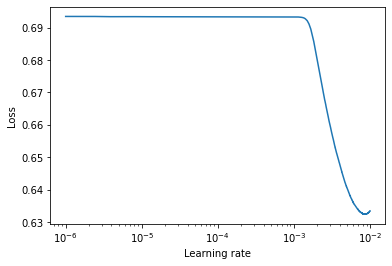

In [ ]:

import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import Callback

class LRFinder(tf.keras.callbacks.Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

batch_size = 130
tune_model = CFmodel()

lr_finder = LRFinder(min_lr=1e-6, 
                    max_lr=1e-2, 
                    steps_per_epoch=np.ceil(x_train.shape[0]/batch_size), 
                    epochs=1)
tune_model.fit(x = x_train, y = y_train, verbose = 2, callbacks = [lr_finder], batch_size = batch_size)

lr_finder.plot_loss()

In [ ]:

# tune_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = keras.optimizers.Adam(1e-6)) #0.00003

# Define Model training functions

Train model

In [ ]:
def train_CFmodel(model, x_aug_train, y_train,x_aug_test, y_test):
  BATCH_SIZE = 512
  EPOCHS = 20
  train_again = True
  
  callback = tf.keras.callbacks.EarlyStopping(        #check val_loss vs loss which one to consider
      monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='auto',
      baseline=None, restore_best_weights=False
  )
  
  if train_again:
    history = model.fit(x = x_aug_train, y = y_train, batch_size = BATCH_SIZE ,epochs = EPOCHS, verbose = 1, callbacks = [callback], validation_data=(x_aug_test, y_test))

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('eopchs')
  plt.legend(['train','test'], loc = "upper left")
  plt.show()

  return model

In [ ]:
# train_CFmodel(CFmodel(lr = 0.00005), x_train, y_train,x_test, y_test)
# a = Basemodel().predict(x_train)
# print(x_train.shape)
# print(a.shape)

In [ ]:

# train_model(model, x_train, y_train, x_test, y_test)

# Load saved model
just in case

Load saved model 

In [ ]:
def saved_model():
  model = keras.models.load_model(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '6'+ 'refined')
  return model

# RMSE evaluation for the leave one validation set 

Left out rmse

In [ ]:
## utility function to calculate rmse
def rmse(predictions, targets):  
  print(np.squeeze(predictions).shape, np.squeeze(targets).shape)
  print('')
  return np.sqrt(np.mean((np.squeeze(predictions)-np.squeeze(targets))**2))

## function to return datafrmae of rmse evalutaion result
def rmse_evaluate(model, x_train, x_test, y_train, y_test, model_name ):
  BATCH_SIZE_P = 10

  ratings_train = model.predict(np.reshape(np.array(x_train.values),(-1,4)), batch_size = BATCH_SIZE_P).flatten() ##remove .iloc for V1 model
  ratings_test = model.predict(np.reshape(np.array(x_test.values),(-1,4)), batch_size = BATCH_SIZE_P).flatten() ##remove .iloc for V1 model

  rmse_train = rmse(ratings_train, y_train)
  rmse_test = rmse(ratings_test, y_test)

  data = {'model':[model_name], 'rmse train':[rmse_train], 'rmse test':[rmse_test]}
  df = pd.DataFrame(data)

  return df


In [ ]:
def rmse_evaluate_leftout(df_ratings):
  # x_train, x_test, y_train, y_test, global_avg = prepare_data(df_ratings)
  
  ############### prepare data #########
  x_train, x_test, y_train, y_test, global_avg = prepare_data_leftout(df_ratings)

  ############# get model ##############
  num_users = df_ratings['userId'].unique().max() +1
  num_movies = df_ratings['movieId'].unique().max() +1
  # EMBEDDING_SIZE = 60

  lr =  0.002 #2e-2 tune this
  
  model_CF = CFmodel(num_users = num_users, num_movies=num_movies, global_avg = global_avg,hparam =hparam)
  model_base = Basemodel( global_avg = global_avg)
  # model_mu = mumodel( global_avg = global_avg)
  model_CF_pure = CFpure(num_users = num_users, num_movies=num_movies, global_avg = global_avg,hparam =hparam)
  ############ train/load model #############
  train_CF = True # True
  save_CF = True #True
  
  if train_CF or not os.path.isdir(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '7'+'1m'):
    print("CF_Recommender training...")
    model_CF = train_CFmodel(model_CF, x_train, y_train, x_test, y_test)
  else:
    model_CF = keras.models.load_model(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '7'+'1m')
    
  if save_CF:
    model_CF.save(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '7'+ '1m') #'_mu' + '_bias'+'_meaningful_embeddings_allembeddings_he_initialized'
 
 ###############
  save_pure = True
  train_pure = True
  
  if train_pure or not os.path.isdir(base_dir + "Saved Models/"+'CFpure_Recommender'+'_V_'+ '7'+'1m'):
    print("CFpure_Recommender training...")
    model_CF_pure = train_CFmodel(model_CF_pure, x_train, y_train, x_test, y_test)
  else:
    model_CF_pure = keras.models.load_model(base_dir + "Saved Models/"+'CFpure_Recommender'+'_V_'+ '7'+'1m')
  
  if save_pure:
    model_CF_pure.save(base_dir + "Saved Models/"+'CFpure_Recommender'+'_V_'+ '7'+ '1m') #'_mu' + '_bias'+'_meaningful_embeddings_allembeddings_he_initialized'
 
  # model = keras.models.load_model(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '5'+ '_mu' + '_bias'+'_meaningful_embeddings_allembeddings_he_initialized')
  ############ evaluate models #########
  # df = rmse_evaluate(model_mu,x_train, x_test, y_train, y_test,"mu Baseline")


  df = rmse_evaluate(model_base,x_train, x_test, y_train, y_test,"bias Baseline")
  df = df.append(rmse_evaluate(model_CF,x_train, x_test, y_train, y_test,"CF"))
  df = df.append(rmse_evaluate(model_CF_pure,x_train, x_test, y_train, y_test,"CFpure"))
  return(df, model_CF, model_base, model_CF_pure)





Model: "cf_recommender_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     multiple                  181230    
_________________________________________________________________
embedding_13 (Embedding)     multiple                  6041      
_________________________________________________________________
embedding_14 (Embedding)     multiple                  118590    
_________________________________________________________________
embedding_15 (Embedding)     multiple                  3953      
Total params: 309,814
Trainable params: 309,814
Non-trainable params: 0
_________________________________________________________________
Model: "cf_recommender_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     multiple                  181230    
__________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1718/1718 [==============================] - 8s 5ms/step - loss: 0.6386 - val_loss: 0.6041
Epoch 2/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5987 - val_loss: 0.5924
Epoch 3/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5933 - val_loss: 0.5893
Epoch 4/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5902 - val_loss: 0.5879
Epoch 5/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5875 - val_loss: 0.5870
Epoch 6/20
1718/1718 [==============================] - 8s 4ms/step - loss: 0.5849 - val_loss: 0.5865
Epoch 7/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5824 - val_loss: 0.5863
Epoch 8/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5801 - val_loss: 0.5862
Epoch 9/20
1718/1718 [==============================] - 8s 4ms/step - loss: 0.5780 - val_loss: 0.5867


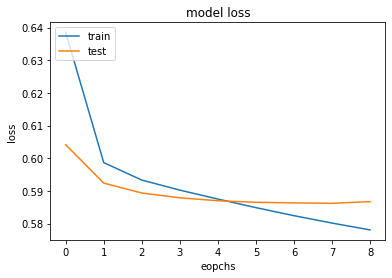

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Machine Learning/movielens1m/Saved Models/CFRecommender_V_71m/assets
CFpure_Recommender training...
Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1718/1718 [==============================] - 8s 5ms/step - loss: 0.6388 - val_loss: 0.6042
Epoch 2/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5993 - val_loss: 0.5930
Epoch 3/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5945 - val_loss: 0.5896
Epoch 4/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5910 - val_loss: 0.5878
Epoch 5/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5877 - val_loss: 0.5869
Epoch 6/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5848 - val_loss: 0.5865
Epoch 7/20
1718/1718 [==============================] - 8s 5ms/step - loss: 0.5822 - val_loss: 0.5862
Epoch 8/20
1718/1718 [==============================] - 8s 4ms/step - loss: 0.5800 - val_loss: 0.5862


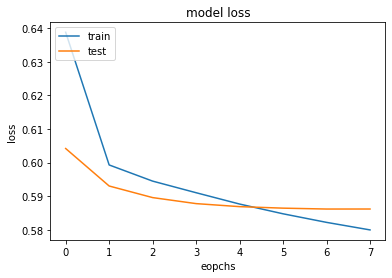

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Machine Learning/movielens1m/Saved Models/CFpure_Recommender_V_71m/assets
(879409,) (879409,)

(120800,) (120800,)

(879409,) (879409,)

(120800,) (120800,)

(879409,) (879409,)

(120800,) (120800,)



In [ ]:
df1, model_CF1, model_base1, model_CF_pure1 = rmse_evaluate_leftout(df_ratings)

In [ ]:
display(df1) 
# val_loss instead of loss
# hparam['lr'] = 0.001
# hparam['embeddings_initializer'] = 'glorot_uniform'
# hparam['embedding_regularization'] = 1+e-6
# hparam['embedding_size'] = 30
# hparam['pure_CF'] = 0

,model,rmse train,rmse test
0,bias Baseline,0.237321,0.244797
0,CF,0.194291,0.236018
0,CFpure,0.197200,0.236195


In [ ]:
display(df1) 
#loss
# hparam['lr'] = 0.001
# hparam['embeddings_initializer'] = 'glorot_uniform'
# hparam['embedding_regularization'] = 1e-6
# hparam['embedding_size'] = 30
# hparam['pure_CF'] = 0

,model,rmse train,rmse test
0,bias Baseline,0.237321,0.244797
0,CF,0.174360,0.236544
0,CFpure,0.174650,0.236769


In [ ]:
display(df1) #tuned model 0.01,he,40,1e-6,patience 1, loss

,model,rmse train,rmse test
0,bias Baseline,0.237321,0.244797
0,CF,0.183675,0.242563
0,CFpure,0.183939,0.243599


In [ ]:
display(df1) #1m, patience 1, loss, embedding dim 60,lr 0.002

In [ ]:
display(df1) #1m, patience 1, loss, embedding dim 70,lr 0.002

In [ ]:
display(df1) #1m, patience 1, loss, embedding dim 60,lr 0.002 ep = 20

In [ ]:
display(df1) #1m, patience 1, loss, embedding dim 50,lr 0.002 ep = 20

In [ ]:
display(df1)

In [ ]:
display(df1) #1m, patience 1, val_loss, embedding dim 60,lr 0.002 ,ep 20

In [ ]:
display(df1) #1m, patience 1, val_loss, embedding dim 60,lr 0.002 ,ep 20 reg 1e-3

In [ ]:
display(df1) #1m, patience 1, loss, embedding dim 60,lr 0.002 ,ep 20 reg 1e-3

# Old rmse evaluation

doesnt work, remove this code

Evaluate model

RMSE evaluation

In [ ]:
## utility function to calculate rmse
def rmse(predictions, targets):  
  print(np.squeeze(predictions).shape, np.squeeze(targets).shape)
  print('')
  return np.sqrt(np.mean((np.squeeze(predictions)-np.squeeze(targets))**2))

## function to return datafrmae of rmse evalutaion result
def rmse_evaluate(model, x_train, x_test, y_train, y_test, model_name ):
  BATCH_SIZE_P = 10

  ratings_train = model.predict(np.reshape(np.array(x_train.values),(-1,4)), batch_size = BATCH_SIZE_P).flatten() ##remove .iloc for V1 model
  ratings_test = model.predict(np.reshape(np.array(x_test.values),(-1,4)), batch_size = BATCH_SIZE_P).flatten() ##remove .iloc for V1 model

  rmse_train = rmse(ratings_train, y_train)
  rmse_test = rmse(ratings_test, y_test)

  data = {'model':[model_name], 'rmse train':[rmse_train], 'rmse test':[rmse_test]}
  df = pd.DataFrame(data)

  return df


In [ ]:
def rmse_evaluate_main(df_ratings):
  # x_train, x_test, y_train, y_test, global_avg = prepare_data(df_ratings)
  
  ############### prepare data #########
  x_train, x_test, y_train, y_test, global_avg = prepare_data(df_ratings)

  ############# get model ##############
  num_users = df_ratings['userId'].unique().max() +1
  num_movies = df_ratings['movieId'].unique().max() +1
  EMBEDDING_SIZE = 50

  lr =  0.002 #2e-2 tune this
  
  model_CF = CFmodel(num_users = num_users, num_movies=num_movies, EMBEDDING_SIZE =EMBEDDING_SIZE, global_avg = global_avg, lr = lr)
  model_base = Basemodel( global_avg = global_avg)
  # model_mu = mumodel( global_avg = global_avg)
  model_CF_pure = CFpure(num_users = num_users, num_movies=num_movies, EMBEDDING_SIZE =EMBEDDING_SIZE, global_avg = global_avg, lr = lr)
  ############ train/load model #############
  train = True # True
  
  if train or not os.path.isdir(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '6'+'refined'):
    model_CF = train_CFmodel(model_CF, x_train, y_train, x_test, y_test)
  else:
    model_CF = keras.models.load_model(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '6'+'refined')
    
  save = True #True
  if save:
    model_CF.save(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '6'+ 'refined') #'_mu' + '_bias'+'_meaningful_embeddings_allembeddings_he_initialized'
 
  model_CF_pure = train_CFmodel(model_CF_pure, x_train, y_train, x_test, y_test)

  # model = keras.models.load_model(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '5'+ '_mu' + '_bias'+'_meaningful_embeddings_allembeddings_he_initialized')
  ############ evaluate models #########
  # df = rmse_evaluate(model_mu,x_train, x_test, y_train, y_test,"mu Baseline")


  df = rmse_evaluate(model_base,x_train, x_test, y_train, y_test,"bias Baseline")
  df = df.append(rmse_evaluate(model_CF,x_train, x_test, y_train, y_test,"CF"))
  df = df.append(rmse_evaluate(model_CF_pure,x_train, x_test, y_train, y_test,"CFpure"))
  return(df, model_CF, model_base, model_CF_pure)





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Model: "cf_recommender"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  302050    
_________________________________________________________________
embedding_1 (Embedding)      multiple                  6041      
_________________________________________________________________
embedding_2 (Embedding)      multiple                  197650    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  3953      
Total params: 509,694
Trainable params: 509,694
Non-trainable params: 0
_________________________________________________________________
Model: "cf_recommender_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  302050    
____________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1759/1759 [==============================] - 11s 6ms/step - loss: 0.6158 - val_loss: 0.7102
Epoch 2/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5970 - val_loss: 0.7160
Epoch 3/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5914 - val_loss: 0.7197
Epoch 4/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5883 - val_loss: 0.7215
Epoch 5/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5867 - val_loss: 0.7225
Epoch 6/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5860 - val_loss: 0.7230
Epoch 7/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5854 - val_loss: 0.7234
Epoch 8/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5851 - val_loss: 0.7236
Epoch 9/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5849 - val_loss: 0.7237
Epoch 10/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5847

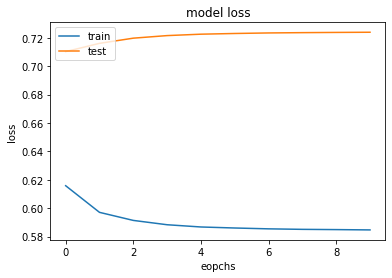

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Machine Learning/movielens1m/Saved Models/CFRecommender_V_6refined/assets
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1759/1759 [==============================] - 12s 7ms/step - loss: 0.6157 - val_loss: 0.7100
Epoch 2/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5971 - val_loss: 0.7160
Epoch 3/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5915 - val_loss: 0.7196
Epoch 4/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5883 - val_loss: 0.7214
Epoch 5/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5867 - val_loss: 0.7224
Epoch 6/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5860 - val_loss: 0.7230
Epoch 7/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5853 - val_loss: 0.7233
Epoch 8/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5849 - val_loss: 0.7235
Epoch 9/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5846 - val_loss: 0.7237
Epoch 10/10
1759/1759 [==============================] - 11s 6ms/step - loss: 0.5844

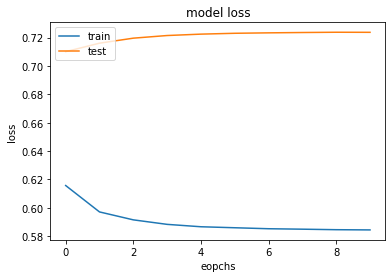

(900188,) (900188,)

(100021,) (100021,)

(900188,) (900188,)

(100021,) (100021,)

(900188,) (900188,)

(100021,) (100021,)



In [ ]:
df, model_CF, model_base, model_CF_pure = rmse_evaluate_main(df_ratings)

In [ ]:
display(df)

,model,rmse train,rmse test
0,bias Baseline,0.237359,0.256709
0,CF,0.168583,0.319274
0,CFpure,0.168314,0.319254


In [ ]:
# model_CF.save(base_dir + "Saved Models/"+'CFRecommender'+'_V_'+ '6'+ 'refined') #'_mu' + '_bias'+'_meaningful_embeddings_allembeddings_he_initialized'

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Machine Learning/movielens1m/Saved Models/CFRecommender_V_6refined/assets


# Explore embeddings and see predictions
todo- add tSNE of embeddings classified on genre

Analyse Embeddings


In [ ]:
def sim(model, df_movies, id=1):

  movie_embedding = model.layers[2]
  weights = movie_embedding.get_weights()[0]
  # print(weights)
  # print(weights.shape)


  id =id #122912	 #189333 mi #184641 fma #122912 infinity w #593 silence #215 before sunrise #6710+42 dark knight #318 shawshank   #187593 dp #68791 terminator # 4369 ff #122916 thor #1210 starwars
  similarity = np.dot(weights,weights[id,:].T)/(np.linalg.norm(weights,axis =1)+0.00000001)/(np.linalg.norm(weights[id,:])+0.00000001)
  # print(similarity.shape)
  sim = pd.DataFrame(similarity)
  sim['movieId'] = np.arange(df_movies['movieId'].unique().max()+1)
  sim.columns = ['similarity', 'movieId']
  sim = sim.merge(df_movies, on = 'movieId')
  sim = sim.sort_values(by = 'similarity', ascending = False)
  display(sim[:15])
  display(sim[-5:])

In [ ]:
model_CF = saved_model()
sim(model_CF,df_movies,1)

,similarity,movieId,title,genres
0,1.000000,1,Toy Story (1995),Animation|Children's|Comedy
3045,0.825308,3114,Toy Story 2 (1999),Animation|Children's|Comedy
2286,0.723963,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy
360,0.652019,364,"Lion King, The (1994)",Animation|Children's|Musical
584,0.610675,588,Aladdin (1992),Animation|Children's|Comedy|Musical
2728,0.606673,2797,Big (1988),Comedy|Fantasy
2182,0.597607,2251,"Cabinet of Dr. Ramirez, The (1991)",Comedy
1636,0.593955,1682,"Truman Show, The (1998)",Drama
3438,0.589344,3507,"Odd Couple, The (1968)",Comedy
3682,0.586581,3751,Chicken Run (2000),Animation|Children's|Comedy


,similarity,movieId,title,genres
3596,-0.531322,3665,Curse of the Puppet Master (1998),Horror|Sci-Fi|Thriller
2974,-0.539228,3043,Meatballs 4 (1992),Comedy
654,-0.558108,660,August (1996),Drama
218,-0.612164,220,Castle Freak (1995),Horror
3082,-0.618153,3151,"Bat Whispers, The (1930)",Crime|Drama|Mystery


In [ ]:
sim(model_CF_pure,df_movies,215)

,similarity,movieId,title,genres
213,1.000000,215,Before Sunrise (1995),Drama|Romance
2628,0.642365,2697,My Son the Fanatic (1998),Comedy|Drama|Romance
1257,0.601406,1277,Cyrano de Bergerac (1990),Action|Drama|Romance
1199,0.588046,1217,Ran (1985),Drama|War
1866,0.576703,1935,How Green Was My Valley (1941),Drama
2424,0.558626,2493,"Harmonists, The (1997)",Drama
3401,0.553757,3470,Dersu Uzala (1974),Adventure|Drama
1831,0.535995,1900,"Children of Heaven, The (Bacheha-Ye Aseman) (1...",Drama
2863,0.532223,2932,Days of Heaven (1978),Drama
1115,0.518218,1131,Jean de Florette (1986),Drama


,similarity,movieId,title,genres
2468,-0.412337,2537,Beyond the Poseidon Adventure (1979),Adventure
1600,-0.423138,1646,Rocket Man (1997),Comedy
2746,-0.446296,2815,Iron Eagle (1986),Action|War
3362,-0.452282,3431,Death Wish II (1982),Action|Drama
3876,-0.472776,3946,Get Carter (2000),Action|Drama|Thriller


In [ ]:
sim(CFmodel(),df_movies,1)

Model: "cf_recommender"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  181230    
_________________________________________________________________
embedding_1 (Embedding)      multiple                  6041      
_________________________________________________________________
embedding_2 (Embedding)      multiple                  118590    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  3953      
Total params: 309,814
Trainable params: 309,814
Non-trainable params: 0
_________________________________________________________________


,similarity,movieId,title,genres
0,1.000000,1,Toy Story (1995),Animation|Children's|Comedy
26,0.622563,27,Now and Then (1995),Drama
2580,0.615697,2649,Son of Frankenstein (1939),Horror
1623,0.550291,1669,"Tango Lesson, The (1997)",Romance
3678,0.522904,3747,Jesus' Son (1999),Drama
1624,0.517774,1670,Welcome To Sarajevo (1997),Drama|War
92,0.510233,94,Beautiful Girls (1996),Drama
2597,0.509824,2666,It Conquered the World (1956),Sci-Fi
2130,0.507234,2199,Phoenix (1998),Crime|Drama
997,0.502151,1010,"Love Bug, The (1969)",Children's|Comedy


,similarity,movieId,title,genres
2002,-0.534181,2071,And the Band Played On (1993),Drama
3104,-0.535154,3173,Any Given Sunday (1999),Drama
3751,-0.560818,3821,Nutty Professor II: The Klumps (2000),Comedy
334,-0.568549,338,Virtuosity (1995),Sci-Fi|Thriller
817,-0.665592,828,"Adventures of Pinocchio, The (1996)",Adventure|Children's


In [ ]:
# tf.zeros([5]) + 8

# keras tuner

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 61kB 3.1MB/s 


In [ ]:
x_train, x_test, y_train, y_test, global_avg = prepare_data_leftout(df_ratings, 20)
num_users = df_ratings['userId'].unique().max() +1
num_movies = df_ratings['movieId'].unique().max() +1
  

def model_builder(hp):
  # model = keras.Sequential()
  # model.add(keras.layers.Flatten(input_shape=(28, 28)))
  ######################################################
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  # hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  # model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  # model.add(keras.layers.Dense(10))

  hp_embedding = hp.Int('embedding_size', min_value = 30, max_value = 80, step = 10)
  hp_lr = hp.Choice('learning_rate', values = [1e-2, 6e-3, 3e-3 ,1e-3, 1e-4]) 
  hp_emb_init = hp.Choice('embeddings_initializer',values = ["glorot_uniform", "he_uniform"])
  hp_reg = hp.Choice('embedding_regularization', values = [1e-2, 1e-3,1e-4,1e-5,1e-6])
  hp_pure = hp.Choice('pure CF model', values = [True, False])
  import keras.backend as K
  class CFRecommender(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, global_avg,hp_emb_init,hp_reg, hp_pure):
      super().__init__()#CFRecommender, self
      self.num_users = num_users
      self.num_movies = num_movies
      self.embedding_size = embedding_size
      self.global_avg = global_avg
      self.hp_emb_init = hp_emb_init
      self.hp_pure = hp_pure
      self.hp_reg = hp_reg 
      # self.user_mean_bias = user_mean_bias
      # self.movie_mean_bias = movie_mean_bias

      self.user_embedding = tf.keras.layers.Embedding(self.num_users,self.embedding_size,embeddings_regularizer=keras.regularizers.l2(hp_reg),embeddings_initializer=hp_emb_init)
      self.user_bias = tf.keras.layers.Embedding(self.num_users, 1,embeddings_initializer=hp_emb_init) #, self.embedding_size embeddings_regularizer=keras.regularizers.l2(1e-6),

      self.movie_embedding = tf.keras.layers.Embedding(self.num_movies, self.embedding_size,embeddings_regularizer=keras.regularizers.l2(hp_reg),embeddings_initializer=hp_emb_init)
      self.movie_bias = tf.keras.layers.Embedding(self.num_movies, 1,embeddings_initializer=hp_emb_init) #, self.embedding_size

    def call(self, inputs): #input: dim1 x 2

      user_vector = self.user_embedding(inputs[:,0]) #dim1 x embedding_size
      user_bias = self.user_bias(inputs[:,0]) #dim1 x 1

      movie_vector = self.movie_embedding(inputs[:,1]) #dim1 x embedding_size
      movie_bias = self.movie_bias(inputs[:,1]) #dim1 x 1

      mu = self.global_avg

      # user_avg = self.user_mean_bias.loc[inputs[:,0]].values
      # movie_avg = self.movie_mean_bias.loc[inputs[:,1]].values
      user_avg = inputs[:,2] #dim1 x 1
      movie_avg = inputs[:,3] #dim1 x 1

      """
      user_vector, movie_vector : (batch_size, embedding_dim)
      """
      dot_user_movie = tf.reduce_sum(tf.math.multiply(user_vector,movie_vector), axis = 1) #tf.math.l2_normalize(user_vector,0) # tf.math.l2_normalize(movie_vector,0)  #dim1 x 1
      # print('test0')
      # print(K.int_shape(user_avg[:,np.newaxis]), K.int_shape(user_bias))
      # print(K.int_shape(dot_user_movie), K.int_shape(tf.math.multiply(user_avg[:,np.newaxis],user_bias)),K.int_shape(tf.math.multiply(movie_avg[:,np.newaxis],movie_bias)) )
      # print('test1')
      
      if hp_pure == True:
        c_ratings = dot_user_movie
      else:  
        c_ratings = dot_user_movie + tf.math.multiply(user_avg,user_bias) + tf.math.multiply(movie_avg,movie_bias) + mu
      # print('test2')

      return tf.nn.sigmoid(dot_user_movie)


  model = CFRecommender(num_users, num_movies, hp_embedding, global_avg,hp_emb_init,hp_reg, hp_pure)
  model.build(input_shape=(None,4))
  # model.summary()

  #######################################################
  
  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  # hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = keras.optimizers.Adam(hp_lr))#, metrics = ['acc']
  
  # model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
  #               loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
  #               metrics = ['accuracy'])
  
  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = "/content/gdrive/My Drive/Machine Learning/movielens1m"+ 'my_dir',
                     project_name = 'intro_to_kt')    

INFO:tensorflow:Reloading Oracle from existing project /content/gdrive/My Drive/Machine Learning/movielens1mmy_dir/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from /content/gdrive/My Drive/Machine Learning/movielens1mmy_dir/intro_to_kt/tuner0.json


In [ ]:
# callback = tf.keras.callbacks.EarlyStopping(        #check val_loss vs loss which one to consider
#       monitor='loss', min_delta=0, patience=1, verbose=0, mode='auto',
#       baseline=None, restore_best_weights=False
#   )

In [ ]:
!pip install IPython
from IPython.display import clear_output

In [ ]:
import IPython
import IPython.display

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner.search(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), callbacks = [ClearTrainingOutput()] , batch_size = 512)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 

learning_rate = {best_hps.get('learning_rate')}
embedding_size = {best_hps.get('embedding_size')}
embeddings_initializer = {best_hps.get('embeddings_initializer')}
embedding_regularization = {best_hps.get('embedding_regularization')}
pure CF model = {best_hps.get('pure CF model')}

""")

Epoch 5/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1718/1718 [==============================] - 11s 6ms/step - loss: 0.6160 - val_loss: 0.5947
Epoch 6/10
1718/1718 [==============================] - 11s 6ms/step - loss: 0.5905 - val_loss: 0.5926
Epoch 7/10
1015/1718 [================>.............]Buffered data was truncated after reaching the output size limit.

In [ ]:

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:

print(f"""
The hyperparameter search is complete. 

learning_rate = {best_hps.get('learning_rate')}
embedding_size = {best_hps.get('embedding_size')}
embeddings_initializer = {best_hps.get('embeddings_initializer')}
embedding_regularization = {best_hps.get('embedding_regularization')}
pure CF model = {best_hps.get('pure CF model')}

""")


The hyperparameter search is complete. 

learning_rate = 0.001
embedding_size = 30
embeddings_initializer = glorot_uniform
embedding_regularization = 1e-06
pure CF model = 1




# Hit Rate on the 1m dataset  
Not working. Hit rate is always 0. Find the bug.

In [ ]:
def split_train_eval(df_ratings, k):
  """
  returns train set and eval set
  """
  # df_ratings['user_mean_bias'] = user_mean_bias.loc[df_ratings['userId'].values].values                   #comment for v1
  # df_ratings['movie_mean_bias'] = movie_mean_bias.loc[df_ratings['movieId'].values].values                   #comment for v1

  leftOutPredictions =df_ratings.groupby('userId', as_index = False).apply(lambda x: x.iloc[-k:,:])
  
  # print(leftOutPredictions)

  # df_ratings_train = df_ratings[~(df_ratings.isin(leftOutPredictions.values))]
  df_ratings_train = df_ratings.groupby('userId', as_index = False).apply(lambda x: x.iloc[:-k,:])#.reset_index(drop = True,inplace =True)
  df_ratings_train.index = pd.RangeIndex(len(df_ratings_train.index))

  # display(df_ratings_train)

  return df_ratings_train, leftOutPredictions

In [ ]:
def mean_biases(df_ratings, k=1):
  y_min = min(df_ratings['rating'].values)
  y_max = max(df_ratings['rating'].values)

  df_ratings['rating'] = (df_ratings['rating'] - y_min)/ (y_max - y_min)

  # split_index = int(0.9*df_ratings.shape[0]) 
  df_ratings_train, df_ratings_test = split_train_eval(df_ratings, k)
  # df_ratings_train, df_ratings_test = df_ratings.iloc[:split_index], df_ratings.iloc[split_index:]

  global_avg = df_ratings_train['rating'].sum()/df_ratings_train.shape[0] 
  # print(global_avg)
  user_mean_bias = df_ratings_train.groupby('userId')['rating'].agg('mean') - global_avg
  movie_mean_bias = df_ratings_train.groupby('movieId')['rating'].agg('mean')  - global_avg

  all_user_mean_bias = pd.Series(np.zeros(df_ratings['userId'].unique().max()+1))#, columns = ['userId']
  all_movie_mean_bias = pd.Series(np.zeros(df_ratings['movieId'].unique().max()+1))#, columns = ['movieId']

  all_user_mean_bias.update(user_mean_bias)#, overwrite = True
  all_movie_mean_bias.update(movie_mean_bias)#, overwrite = True
  
  user_mean_bias = all_user_mean_bias
  movie_mean_bias = all_movie_mean_bias
  
  return user_mean_bias, movie_mean_bias

In [ ]:
def prepare_data_hitrate(df_ratings, k=1):

  y_min = min(df_ratings['rating'].values)
  y_max = max(df_ratings['rating'].values)

  df_ratings['rating'] = (df_ratings['rating'] - y_min)/ (y_max - y_min)

  split_index = int(0.9*df_ratings.shape[0]) 
  df_ratings_train, df_ratings_test = split_train_eval(df_ratings, k)
  # df_ratings_train, df_ratings_test = df_ratings.iloc[:split_index], df_ratings.iloc[split_index:]

  global_avg = df_ratings_train['rating'].sum()/df_ratings_train.shape[0] 
  # print(global_avg)
  user_mean_bias = df_ratings_train.groupby('userId')['rating'].agg('mean') - global_avg
  movie_mean_bias = df_ratings_train.groupby('movieId')['rating'].agg('mean')  - global_avg

  all_user_mean_bias = pd.Series(np.zeros(df_ratings['userId'].unique().max()+1))#, columns = ['userId']
  all_movie_mean_bias = pd.Series(np.zeros(df_ratings['movieId'].unique().max()+1))#, columns = ['movieId']

  all_user_mean_bias.update(user_mean_bias)#, overwrite = True
  all_movie_mean_bias.update(movie_mean_bias)#, overwrite = True
  
  user_mean_bias = all_user_mean_bias
  movie_mean_bias = all_movie_mean_bias
  
  df_ratings_train['user_mean_bias'] = user_mean_bias.loc[df_ratings_train['userId'].values].values
  df_ratings_train['movie_mean_bias'] = movie_mean_bias.loc[df_ratings_train['movieId'].values].values

  df_ratings_test['user_mean_bias'] = user_mean_bias.loc[df_ratings_test['userId'].values].values
  df_ratings_test['movie_mean_bias'] = movie_mean_bias.loc[df_ratings_test['movieId'].values].values

  # x_train, x_test, y_train, y_test = df_ratings_train[['userId', 'movieId','user_mean_bias','movie_mean_bias']], df_ratings_test[['userId', 'movieId','user_mean_bias','movie_mean_bias']], df_ratings_train[['rating']], df_ratings_test[['rating']]
  
  # return x_train, x_test, y_train, y_test, global_avg
  return df_ratings_train, df_ratings_test

In [ ]:
# df_ratings_train, leftOutPredictions = prepare_data_hitrate(df_ratings)

In [ ]:

def HitRate(topNPredicted, leftOutPredictions): 
  '''
  leftOutPredictions : numpy array of the last rating from each user (num_users,3 ie userid, movieid, predictedRating)
  topNPredicted : numpy array of the top N predicted movies for each user (num_users, N ie top, 3 ie movied, predictedRating)
  '''
  hits = 0.0
  total = 0.0
  # print(leftOutPredictions)
 # For each left-out rating
  for leftOut in leftOutPredictions:
      userID = leftOut[0]
      # print(userID)
      leftOutMovieID = leftOut[1]
      # print("leftOutMovieID=",leftOutMovieID)
      # print(leftOutMovieID)
      # Is it in the predicted top 10 for this user?
      hit = False
      for predicted in topNPredicted[int(userID)-1]:
          movieID, predictedRating = predicted[0], predicted[1]
          # print("(movieID)=",int(movieID))
          if (int(leftOutMovieID) == int(movieID)):
              hit = True
              break
      if (hit) :
          hits += 1.0

      total += 1.0

  # Compute overall precision
  return (hits*1.0)/(total*1.0)

# print("\nHit Rate: ", HitRate(topNPredicted, leftOutPredictions))

In [ ]:
def not_watched(model, leftOutPredictions, df_ratings):
  # predictions = model.predict(leftOutPrediction.iloc[:,0], batch_size = BATCH_SIZE_P).flatten()

  users = leftOutPredictions.iloc[:,0]    #series of users
  # movies = df_movies['movieId']
  movies = df_ratings['movieId'].unique()

  user_mean_bias , movie_mean_bias =  mean_biases(df_ratings)  
  # display(users)
  # display(movies)

  df_all = pd.DataFrame([(i,s) for i in users for s in movies], columns = ['userId','movieId'])

  df_all['user_mean_bias'] = user_mean_bias.loc[df_all['userId'].values].values     
  df_all['movie_mean_bias'] = movie_mean_bias.loc[df_all['movieId'].values].values     

  # display(df_all)

  # display(df_ratings)
  # df = pd.DataFrame([(i, s) for i in id for s in st], columns=['id', 'st'])
  movies_not_watched = df_all.merge(df_ratings[['userId','movieId']],how = 'outer',on = ['userId','movieId'], indicator = True)
  # merged = pd.merge(A,B, how='outer', indicator=True)
  # merged[merged['_merge'] == 'left_only']
  movies_not_watched = movies_not_watched[movies_not_watched['_merge'] == 'left_only']
  movies_not_watched.drop(columns = ['_merge'], inplace = True)
  movies_not_watched.reset_index(drop = True, inplace = True)
  # movies_not_watched = movies_not_watched[['userId','movieId']]
  
  # display(movies_not_watched)

  
  # print(ratings.shape)
  # print(movies_not_watched.shape)

  #BATCH_SIZE_P should be divisible by 
  BATCH_SIZE_P = 512 #98    #142 #33
  #
  # print(np.reshape(np.array(movies_not_watched.values, dtype = np.float),(-1,4)).shape)

  ratings = model.predict(np.reshape(np.array(movies_not_watched.values, dtype = np.float),(-1,4)), verbose = 2, batch_size = BATCH_SIZE_P)#.flatten() ##remove .iloc for V1 model
  movies_not_watched['ratings'] = ratings

  return movies_not_watched

In [ ]:
def predictN(movies_not_watched, N):
 
  print("movies_not_watched: ",movies_not_watched.shape)
  movies_not_watched['new']=movies_not_watched.groupby('userId').cumcount()
  df_true=movies_not_watched.set_index(['userId','new']).unstack(fill_value=0).stack(dropna=False).reset_index('userId').reset_index( drop = True)
  print("df_true:", df_true.shape)
  topN = df_true.groupby('userId')[['movieId','ratings']].apply(lambda x: x.nlargest(N, columns=['ratings']))  #.sort_values(by = 'ratings', ascending = False)[:N] #['movieId']
  display("topN: ",topN.shape)
  
  # print("topN.values.shape",topN.values.shape)

  # print(topN.values)
  # print("np.array(topN).shape",np.array(topN).shape)
  # print("np.array(topN.values).shape",np.array(topN.values).shape)
  topN_array = np.reshape(np.array(topN),newshape = (6040, N,2))
  
  # print(topN.values)


  return topN_array



In [ ]:
# movies_not_watched = not_watched(model, leftOutPredictions)

In [ ]:
# topNpredicted = predictN(movies_not_watched, 1000)
# HitRate(topNpredicted,leftOutPredictions.values)#topNpredicted

In [ ]:
import matplotlib.pyplot as plt

def evaluate_hitrate(df_ratings, model,minN=10, maxN = 2000):      #, model,df_movies
  

  df_ratings_train, leftOutPredictions = prepare_data_hitrate(df_ratings)    #leftOutPrediction : (num_user, 5)

  # model = getModel()
  # model = CFmodel(num_users = num_users, num_movies=num_movies, global_avg = global_avg,hparam =hparam)
  # model = train_CFmodel(model, x_train, y_train, x_test, y_test)
  
  # model = train_model(model, df_ratings_train)
  movies_not_watched = not_watched(model, leftOutPredictions,df_ratings)
  # topNpredicted = predictN(movies_not_watched, 10)

  hit_list = []
  for n in range(minN,maxN+1):
    topNPredicted = predictN(movies_not_watched,n)
    hit_rate = HitRate(topNPredicted, leftOutPredictions.values)
    print("Hit rate at ",n,":= ",hit_rate)
    hit_list.append(hit_rate)
  
  return hit_list


  # plot(hit_list)

  

  '''user : the subset of df_ratings for which user = userid'''
  # user = df_ratings[df_ratings['userId']==user_id]
  # movies_watched_id = user["movieId"]           #df_ratings[ df_ratings['movieId'].isin(user['movieId'].unique())]['movieId']
  # print(movies_watched_id)

  '''movies watched : contains names of the movies the user has watched'''
  # movies_watched = df_movies[df_movies['movieId'].isin(movies_watched_id)]['title']                   #.reset_index() 
  # movies_loved = df_movies[df_movies['movieId'].isin(user[user['rating'].values>0.6].sort_values(by = 'rating', ascending = False)['movieId'])][:30][['title','genres']]

  # print("Movies user {} loved! : ".format(user_id))
  # print("*"*30)
  # display(movies_loved.head(20))
  
  # print("*"*30) 


In [ ]:
# x = evaluate(x_aug,model,20,200)
saved = True

if saved:
  model = saved_model()
else:
  model = CFmodel(num_users = num_users, num_movies=num_movies, global_avg = global_avg,hparam =hparam)
  

In [ ]:
hitrate_result = evaluate_hitrate(df_ratings, model,minN=3930, maxN = 3952)
hitrate_result

41766/41766 - 43s
movies_not_watched:  (21384031, 5)
df_true: (22263440, 5)


'topN: '

(22263440, 2)

ValueError: ignored

# Visualizing the embeddings
Use df_movies and embedding data of all movies to make an altair plot of the tSNE on embeddings clustered by genre.

# To do  
1. Ensure that all user bias which havent been updated from the training dataset are initialized to mu instead of 0.  
  
  Prepare data-> prepare_data_leftout->all_user_mean_bias = pd.Series(np.zeros(df_ratings['userId'].unique().max()+1))
    
    change this to all_user_mean_bias = pd.Series(np.zeroslike(df_ratings['userId'].unique().max()+1), mu)

    Retrain and evaluate the accuracy
  

2. Analyse the hitrate functions and manually check one example to see where is the error.  

    Even random guessing should give >0 hitrate when N=3500(total movies ~= 3880)


3. Recover 22.6 rmse. This was obtained before the model tuning.

4. tSNE on Embeddings, add it to df_movies and cluster according to genre. Plot suing Altair. References: Google developers recommender system link has a plot.

5. **Publish it to Github**

In [ ]:
# df = pd.DataFrame({"id": [100, 200, 200, 300, 300, 300], "val1": [1.5, 2.5, 4.5, np.nan, 6.5, np.nan], "val2": [9.5, 7.5, 8.5, 3.5, np.nan, np.nan]})
# df

,id,val1,val2
0,100,1.5,9.5
1,200,2.5,7.5
2,200,4.5,8.5
3,300,NaN,3.5
4,300,6.5,NaN
5,300,NaN,NaN


In [ ]:
# df['new']=df.groupby('id').cumcount()
# df_true=df.set_index(['id','new']).unstack(fill_value=0).stack(dropna=False).reset_index('id').reset_index( drop = True)
# display(df_true)

,id,val1,val2
0,100,1.5,9.5
1,100,0.0,0.0
2,100,0.0,0.0
3,200,2.5,7.5
4,200,4.5,8.5
5,200,0.0,0.0
6,300,NaN,3.5
7,300,6.5,NaN
8,300,NaN,NaN


In [ ]:
# df_true.columns

Index(['id', 'val1', 'val2'], dtype='object')

In [ ]:
# df_true.index.name

In [ ]:
# df_true.index

RangeIndex(start=0, stop=9, step=1)